# 在卷积神经网络中使用更多的图片(调整图片大小)
主要参考于[DeepLearning.ai课程](https://github.com/lmoroney/dlaicourse)

在之前的课程中，您了解了如何使用CNN来更有效地识别手写数字。 在本课程中，您将把它带入一个新的水平，识别猫和狗的真实图像，以便将传入的图像分类为猫或狗。 在手写识别中，因为所有图像均具有相同的大小和形状，并且均为单色，因此使您的工作更加轻松。 但是现实世界中的图像并非如此-它们具有不同的形状，宽高比等，而且通常是彩色的！

因此，作为任务的一部分，您需要处理数据：尤其是调整其大小以使其形状一致。

您将按照以下步骤操作：
* 探索猫和狗的示例数据
* 建立和训练神经网络以识别两者之间的差异
* 评估训练集和验证集的准确性

## 1. 探讨样本数据


让我们从下载示例数据开始，该示例数据是2,000张猫和狗JPG图片的.zip文件，并在/ tmp中本地提取。

**注：**本练习中使用的2,000张图像摘自[Kaggle上的“狗与猫”数据集](https://www.kaggle.com/c/dogs-vs-cats/data)，其中包含25,000张图像。 在这里，我们使用完整数据集的一个子集来减少出于教育目的的训练时间。

下面的python代码将使用OS库来使用操作系统库，使您能够访问文件系统，而zipfile库允许您解压缩数据。

In [13]:
import os
import zipfile

local_zip = 'tmp\cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp')
zip_ref.close()

.zip的内容被提取到基本目录tmp / cats_and_dogs_filtered中，该目录包含用于训练和验证数据集的训练和验证子目录（有关训练，验证和测试集的更新，请参阅[Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition)），该目录 依次包含猫和狗的子目录。

简而言之，训练集就是用来告诉神经网络模型“这是一只猫的样子”，“这是一只狗的样子”等等的数据。验证数据集是猫和狗的图像，神经网络在训练时不会看到这些图像，所以你可以测试它在评估图像中是猫还是狗时表现得有多好或有多差

在此示例中要注意的一件事：我们没有将图像明确标记为猫或狗。 如果您还记得前面的手写示例，我们将其标记为“这是1”，“这是7”等。稍后，您将看到使用了一个称为ImageGenerator的东西-并将其编码为从子目录读取图像， 并从该子目录的名称中自动标记它们。 因此，例如，您将拥有一个"训练集"目录，其中包含一个“猫”目录和一个“狗”目录。 ImageGenerator将为您适当标记图像，从而减少了编码步骤。

让我们定义每个目录：

In [14]:
base_dir = 'tmp/cats_and_dogs_filtered'

# 获取训练集、验证集目录
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')

# 获取训练集,验证集中猫、狗图片的目录
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

现在，让我们看看猫和狗训练目录中的文件名是什么样子的(验证目录中的文件命名规则相同)

In [15]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


查看训练集和验证集目录中猫和狗图像的总数

In [18]:
print("训练集中猫图片的数量：",len(os.listdir(train_cats_dir)))
print("训练集中狗图片的数量：",len(os.listdir(train_dogs_dir)))
print("验证集中猫图片的数量：",len(os.listdir(validation_cats_dir)))
print("验证集中猫图片的数量：",len(os.listdir(validation_cats_dir)))

训练集中猫图片的数量： 1000
训练集中狗图片的数量： 1000
验证集中猫图片的数量： 500
验证集中猫图片的数量： 500


查看猫、狗的图片

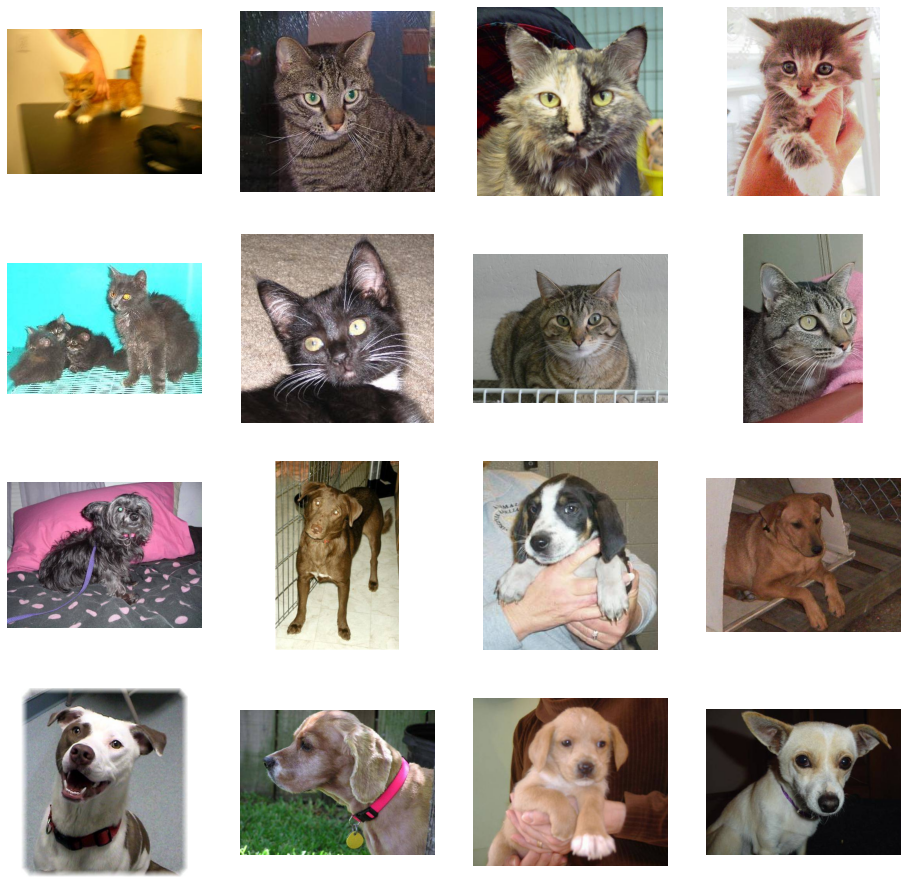

In [23]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pic_index = 0

# 获取当前图表
fig = plt.gcf()

fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows,ncols, i+1)
    sp.axis("off")
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

从这个网格中的图像来看可能不明显，但这里有一个重要的注意，并且与上一课的显著区别是，**这些图像有各种形状和大小。**在进行手写识别示例时，需要处理28x28灰度图像。这些是颜色和各种形状。在训练神经网络之前，你需要调整图像。您将在下一节中看到这一点。

好了，现在你已经知道了你的数据是什么样的了，下一步就是定义一个模型，这个模型将被训练来从这些图像中识别猫或狗

## 2. 建立模型
在上一节中，您看到图像具有各种形状和大小。 为了训练神经网络来处理它们，您需要它们的大小统一。 我们为此选择了150x150，您将很快看到将图像预处理为该形状的代码。

但在我们继续之前，让我们先定义模型：

* 1. 导入库

In [24]:
import tensorflow as tf

* 2. 构建模型：
 * 将像前面一样定义一个序列层，首先添加一些卷积层。注意这次输入的形状参数。在前面的示例中，它是28x28x1，因为图像的灰度值是28x28(8位，1字节表示颜色深度)。这一次，大小为150x150，颜色深度为3(24位，3字节)。
 * 然后添加两个卷积层，并将最终结果压平，以提供给全连接的层。
 * 最后添加全连接层。

**注：**由于我们面临两类分类问题，即二进制分类问题，因此我们将以[Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)激活函数来结束网络，以便网络的输出将是介于0和1之间的单个标量，从而对当前图像预测是1类（而不是0类）。

In [27]:
model = tf.keras.models.Sequential([
    # 第一层
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape = (150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # 第二层
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 第三层
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 第四层
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    # 第五层
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [28]:
# 打印卷积神经网络的层次结构
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

“Output Shape”一栏显示了特征映射在每一层中的大小变化。由于填充，卷积层减少了一点特征映射的大小，而每个池化层将尺寸减半。

接下来，我们将为模型训练配置规范。我们将用二元交叉损耗(binary_crossentropy)来训练我们的模型，因为这是一个二元分类问题，并且我们最终的激活函数是Sigmoid()。(有关损失度量的学习，请参考[ Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture))我们将使用RMSprop优化器，学习率为0.001。在训练期间，我们要监控分类的准确性。


**注意:**在本例子中，使用RMSprop优化算法优于随机梯度下降(SGD)，因为RMSprop可以为我们自动调整学习速率。(其他优化器，如Adam和Adagrad，也会在训练中自动调整学习率，在这里也同样有效。)

In [31]:
from tensorflow.keras.optimizers import RMSprop

# 编译模型
model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

## 3. 数据预处理
让我们建立数据生成器，它将读取源文件夹中的图片，将它们转换为float32张量，并将它们(带有标签)提供给我们的网络。我们将有一个用于训练图像的生成器和一个用于验证图像的生成器。我们的生成器将生成20批大小为150x150的图像及其标签(二进制)。

您可能已经知道，通常应该以某种方式规范化进入神经网络的数据，以使其更易于被网络处理。(将原始像素输入卷积神经网络是很少见的。)在本例中，我们将对图像进行预处理，将像素值归一化为[0,1]范围(最初所有值都在[0,255]范围内)。

在Keras中，规范数据可以通过keras.preprocessing.image.ImageDataGenerator类使用rescale参数来完成。 使用此ImageDataGenerator类，可以通过.flow（数据，标签）或.flow_from_directory（目录）实例化增强图像批处理（及其标签）的生成器。 这些生成器可以与Keras模型方法一起使用，如：接受数据生成器作为输入：fit，evaluate_generator和predict_generator

In [38]:
# 创建一个图片生成器
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 设置数据规范化，并且生层图片生成器对象
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# 实例化训练集生成器
train_generator = train_datagen.flow_from_directory(
    # 训练集目录
    train_dir,
    # 每批生成数据的大小
    batch_size = 20,
    # 分类类别
    class_mode = 'binary',
    # 目标输出大小
    target_size = (150,150)
)

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 4. 训练模型
让我们对15个epoch的所有2,000个可用图像进行训练，并对所有1,000个测试图像进行验证。(这可能需要几分钟的时间。)

**请注意每个时期的值：**

每个时期您将看到4个值：损失，准确度，验证损失和验证准确度。

损失和准确性是训练进度的重要标志。 它正在猜测训练数据的分类，然后根据已知标签对其进行测量，然后计算结果。 准确性是正确猜测的一部分。 验证准确度是对训练中未使用的数据的测量。 如预期的那样，会低一些。 您将在本课程后面的过度拟合部分中了解为什么会发生这种情况。

In [39]:
hoistory = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 15,
                    validation_steps = 50,
                    verbose=2)
'''
verbose：日志显示
verbose = 0 为不在标准输出流输出日志信息
verbose = 1 为输出进度条记录
verbose = 2 为每个epoch输出一行记录
'''

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/15
100/100 - 69s - loss: 0.7542 - accuracy: 0.5465 - val_loss: 0.6849 - val_accuracy: 0.5560
Epoch 2/15
100/100 - 53s - loss: 0.6034 - accuracy: 0.6745 - val_loss: 0.5813 - val_accuracy: 0.6970
Epoch 3/15
100/100 - 55s - loss: 0.5274 - accuracy: 0.7380 - val_loss: 0.5892 - val_accuracy: 0.6910
Epoch 4/15
100/100 - 55s - loss: 0.4475 - accuracy: 0.7930 - val_loss: 0.5518 - val_accuracy: 0.7270
Epoch 5/15
100/100 - 59s - loss: 0.3697 - accuracy: 0.8350 - val_loss: 0.7604 - val_accuracy: 0.6770
Epoch 6/15
100/100 - 61s - loss: 0.2753 - accuracy: 0.8870 - val_loss: 0.6216 - val_accuracy: 0.7180
Epoch 7/15
100/100 - 56s - loss: 0.2230 - accuracy: 0.9185 - val_loss: 0.7551 - val_accuracy: 0.6840
Epoch 8/15
100/100 - 54s - loss: 0.1381 - accuracy: 0.9505 - val_loss: 1.1115 - val_accuracy: 0.6720
Epoch 9/15
100/100 - 53s - loss: 0.1038 - accuracy: 0.9635 - val_loss: 1.0961 - val_accuracy: 0.720

## 5. 运行模型
现在让我们看看如何使用模型实际运行预测。这段代码允许您从文件系统中选择1个或多个文件，然后它将上载它们，并在模型中运行它们，给出对象是狗还是猫的指示。


In [44]:
import numpy as np
from keras.preprocessing import image


fn = 'myimage/3.jpg'
path = 'tmp/' + fn
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0:
    print(fn + " is a dog")
else:
    print(fn + " is a cat")

[1.]
myimage/3.jpg is a dog


## 6. 可视化中间层
为了感受一下我们的卷积网络学习了哪些功能，要做的一件有趣的事情是可视化输入在卷积网络中的转换方式。

让我们从训练集中选择一张随机的猫或狗图像，然后生成一个图形，其中每一行都是图层的输出，而行中的每一幅图像都是该输出要素图中的特定过滤器。 重新运行此单元格以生成各种训练图像的中间表示。

d:\dl\minconda3\envs\ml_dl_andrewng\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


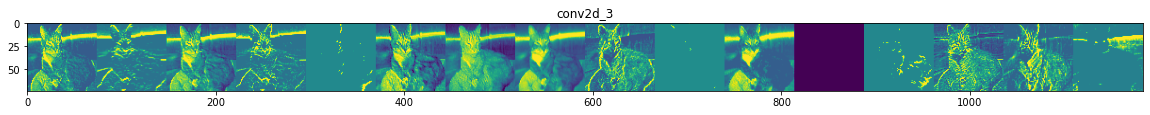

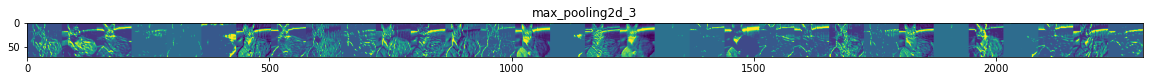

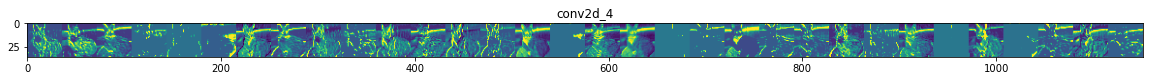

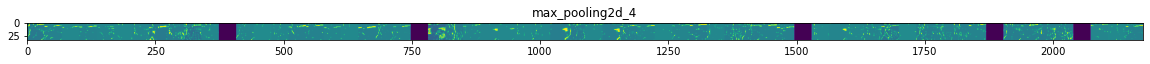

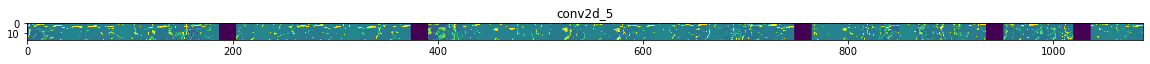

In [47]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# 获得每一层的输出
successive_outputs = [layer.output for layer in model.layers[1:]]

# 获得可视化模型
visualization_model = tf.keras.models.Model(inputs = model.input, outputs=successive_outputs)

# 随机选择一张图片
cat_img_files = [os.path.join(train_cats_dir,f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir,f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path,target_size = (150,150))

# 获得输入的数据
x = img_to_array(img)
x = x.reshape((1,)+x.shape)
# 数据预处理
x /= 255.

# 获得该图片的中间表示层（图片进行特征映射后的数据）
successive_feature_maps = visualization_model.predict(x)

# 获得这些层的名字，以便绘画
layer_names = [layer.name for layer in model.layers]

# 显示中间层
for layer_name,feature_map in zip(layer_names,successive_feature_maps):
    if len(feature_map.shape) == 4: # 只显示卷积层，不显示全连接层
        # 获得该层的神经元的个数（卷积层的通道数）
        n_features = feature_map.shape[-1]
        # (1, size, size, n_features)
        size = feature_map.shape[1]
        
        # 显示该层神经元输出的网格
        display_grid = np.zeros((size,size*n_features))
        
        # 获得该层每个通道进行卷积后映射出的数据，并赋值
        for i in range(n_features):
          x  = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std ()
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x 
        
        # 展示所得到的网格
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )

正如你所看到的，我们从原始像素的图像到越来越抽象和紧凑的表示。下面的表示开始突出显示网络关注的内容，它们显示的被“激活”的特性越来越少;大多数设置为零。这就是所谓的“稀疏性”。表示稀疏性是深度学习的一个关键特征。

这些表示携带越来越少的关于图像原始像素的信息，但越来越精细的关于图像的类的信息。您可以将convnet(通常称为深度网络)视为信息蒸馏管道。

## 7. 评估模型的精度和损失
让我们绘制训练期间收集的训练/验证准确性和损失：

15


Text(0.5, 1.0, 'Training and validation loss')

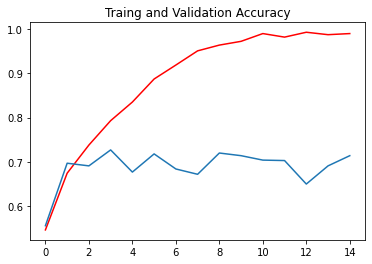

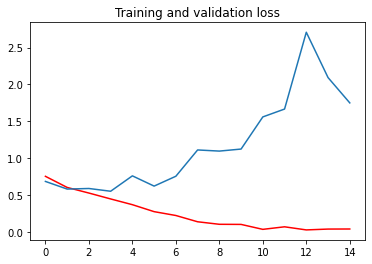

In [56]:
# 获取训练集每一次epoch的数据：
acc = hoistory.history['accuracy']
val_acc = hoistory.history['val_accuracy']
loss = hoistory.history['loss']
val_loss = hoistory.history['val_loss']
print(len(acc))


epochs = range(len(acc))

# 绘制训练集、验证集在每epochs的精确度
plt.plot(epochs,acc,color='red')
plt.plot(epochs,val_acc)
plt.title("Traing and Validation Accuracy")

# 新建一个子图
plt.figure()
# 绘制训练集、验证集在每epochs的损失
plt.plot  ( epochs,     loss ,color='red')
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

正如你所看到的，我们正在过度拟合，就像它正在过时一样。我们的训练精度(红色)接近100%(!)，而验证精度(绿色)停滞在70%。我们的验证损失在仅仅5个epoch后达到最小值。


由于我们的训练集示例数量相对较少（只有2000），因此过度拟合应成为我们的首要考虑因素。 当暴露于过多示例的模型学习无法推广到新数据的模式时，即模型开始使用无关的功能进行预测时，就会发生过度拟合。 例如，如果您作为人类只看到三幅伐木工人的图像和三幅水手的图像，并且其中唯一戴着帽子的人是伐木工人，您可能会开始想到戴帽子 是一个与水手相对的伐木工人的标志。 然后，您将做出一个非常糟糕的伐木工人/水手分类器。

过度拟合是机器学习中的核心问题：鉴于我们将模型的参数拟合到给定的数据集，我们如何确保模型学习的表示形式将适用于从未见过的数据？ 我们如何避免学习特定于训练数据的东西？

在下一个练习中，我们将研究如何防止猫狗分类模型的过拟合。

## 8.清空内存(也许是Colab专用代码)
在运行下一个练习之前，运行以下单元以终止内核并释放内存资源

In [58]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )

AttributeError: module 'signal' has no attribute 'SIGKILL'